# Bayesian Neural Networks in PyMC3
http://pymc-devs.github.io/pymc3/notebooks/bayesian_neural_network_advi.html



## Generating data

First, lets generate some toy data – a simple binary classification problem that’s not linearly separable.

In [2]:
%matplotlib inline
import theano
floatX = theano.config.floatX
import pymc3 as pm
import theano.tensor as T
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.cross_validation import train_test_split
from sklearn.datasets import make_moons

/Users/balarsen/miniconda3/envs/python3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
X, Y = make_moons(noise=0.2, random_state=0, n_samples=1000)
X = scale(X)
X = X.astype(floatX)
Y = Y.astype(floatX)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.5)

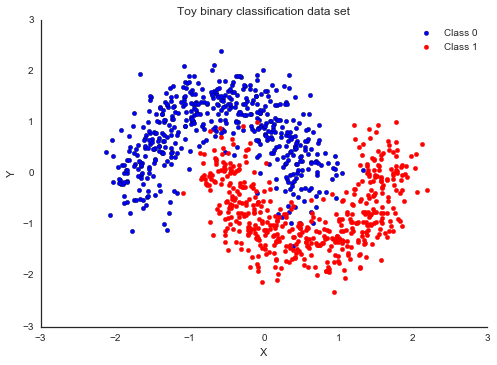

In [4]:
fig, ax = plt.subplots()
ax.scatter(X[Y==0, 0], X[Y==0, 1], label='Class 0')
ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r', label='Class 1')
sns.despine(); ax.legend()
ax.set(xlabel='X', ylabel='Y', title='Toy binary classification data set');

## Model specification

A neural network is quite simple. The basic unit is a perceptron which is nothing more than logistic regression. We use many of these in parallel and then stack them up to get hidden layers. Here we will use 2 hidden layers with 5 neurons each which is sufficient for such a simple problem.

In [5]:
# Trick: Turn inputs and outputs into shared variables.
# It's still the same thing, but we can later change the values of the shared variable
# (to switch in the test-data later) and pymc3 will just use the new data.
# Kind-of like a pointer we can redirect.
# For more info, see: http://deeplearning.net/software/theano/library/compile/shared.html
ann_input = theano.shared(X_train)
ann_output = theano.shared(Y_train)

n_hidden = 5

# Initialize random weights between each layer
init_1 = np.random.randn(X.shape[1], n_hidden).astype(floatX)
init_2 = np.random.randn(n_hidden, n_hidden).astype(floatX)
init_out = np.random.randn(n_hidden).astype(floatX)

with pm.Model() as neural_network:
    # Weights from input to hidden layer
    weights_in_1 = pm.Normal('w_in_1', 0, sd=1,
                             shape=(X.shape[1], n_hidden),
                             testval=init_1)

    # Weights from 1st to 2nd layer
    weights_1_2 = pm.Normal('w_1_2', 0, sd=1,
                            shape=(n_hidden, n_hidden),
                            testval=init_2)

    # Weights from hidden layer to output
    weights_2_out = pm.Normal('w_2_out', 0, sd=1,
                              shape=(n_hidden,),
                              testval=init_out)

    # Build neural-network using tanh activation function
    act_1 = pm.math.tanh(pm.math.dot(ann_input,
                                     weights_in_1))
    act_2 = pm.math.tanh(pm.math.dot(act_1,
                                     weights_1_2))
    act_out = pm.math.sigmoid(pm.math.dot(act_2,
                                          weights_2_out))

    # Binary classification -> Bernoulli likelihood
    out = pm.Bernoulli('out',
                       act_out,
                       observed=ann_output)

That’s not so bad. The Normal priors help regularize the weights. Usually we would add a constant b to the inputs but I omitted it here to keep the code cleaner.

## Variational Inference: Scaling model complexity

We could now just run a MCMC sampler like `NUTS <http://pymc-devs.github.io/pymc3/api.html#nuts>`__ which works pretty well in this case but as I already mentioned, this will become very slow as we scale our model up to deeper architectures with more layers.

Instead, we will use the brand-new ADVI variational inference algorithm which was recently added to PyMC3. This is much faster and will scale better. Note, that this is a mean-field approximation so we ignore correlations in the posterior.

In [6]:
%%time

with neural_network:
    # Run ADVI which returns posterior means, standard deviations, and the evidence lower bound (ELBO)
    v_params = pm.variational.advi(n=50000)

Iteration 0 [0%]: ELBO = -289.23
Iteration 5000 [10%]: Average ELBO = -360.77
Iteration 10000 [20%]: Average ELBO = -253.87
Iteration 15000 [30%]: Average ELBO = -227.02
Iteration 20000 [40%]: Average ELBO = -213.94
Iteration 25000 [50%]: Average ELBO = -199.66
Iteration 30000 [60%]: Average ELBO = -173.59
Iteration 35000 [70%]: Average ELBO = -150.13
Iteration 40000 [80%]: Average ELBO = -136.05
Iteration 45000 [90%]: Average ELBO = -128.99
Finished [100%]: Average ELBO = -125.73
CPU times: user 50.1 s, sys: 2.05 s, total: 52.2 s
Wall time: 1min 23s


< 20 seconds on my older laptop. That’s pretty good considering that NUTS is having a really hard time. Further below we make this even faster. To make it really fly, we probably want to run the Neural Network on the GPU.

As samples are more convenient to work with, we can very quickly draw samples from the variational posterior using sample_vp() (this is just sampling from Normal distributions, so not at all the same like MCMC):

In [9]:
%%time 

with neural_network:
    trace = pm.variational.sample_vp(v_params, draws=5000)

CPU times: user 980 ms, sys: 52.7 ms, total: 1.03 s
Wall time: 2.72 s


Plotting the objective function (ELBO) we can see that the optimization slowly improves the fit over time.



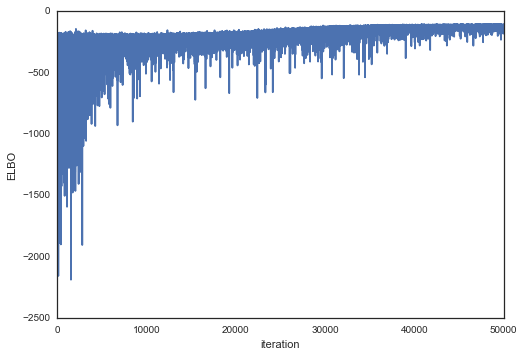

In [10]:
plt.plot(v_params.elbo_vals)
plt.ylabel('ELBO')
plt.xlabel('iteration')

Now that we trained our model, lets predict on the hold-out set using a posterior predictive check (PPC). We use `sample_ppc() <http://pymc-devs.github.io/pymc3/api.html#pymc3.sampling.sample_ppc>`__ to generate new data (in this case class predictions) from the posterior (sampled from the variational estimation).

In [11]:

# Replace shared variables with testing set
ann_input.set_value(X_test)
ann_output.set_value(Y_test)

# Creater posterior predictive samples
ppc = pm.sample_ppc(trace, model=neural_network, samples=500)

# Use probability of > 0.5 to assume prediction of class 1
pred = ppc['out'].mean(axis=0) > 0.5

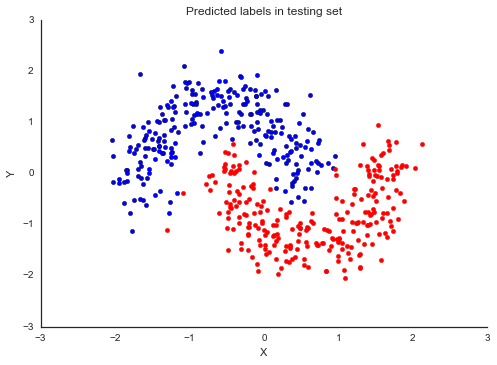

In [12]:
fig, ax = plt.subplots()
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
sns.despine()
ax.set(title='Predicted labels in testing set', xlabel='X', ylabel='Y');

In [13]:
print('Accuracy = {}%'.format((Y_test == pred).mean() * 100))


Accuracy = 96.6%


Hey, our neural network did all right!

## Lets look at what the classifier has learned
For this, we evaluate the class probability predictions on a grid over the whole input space.

In [14]:
grid = np.mgrid[-3:3:100j,-3:3:100j].astype(floatX)
grid_2d = grid.reshape(2, -1).T
dummy_out = np.ones(grid.shape[1], dtype=np.int8)

In [15]:
ann_input.set_value(grid_2d)
ann_output.set_value(dummy_out)

# Creater posterior predictive samples
ppc = pm.sample_ppc(trace, model=neural_network, samples=500)

## Probability surface



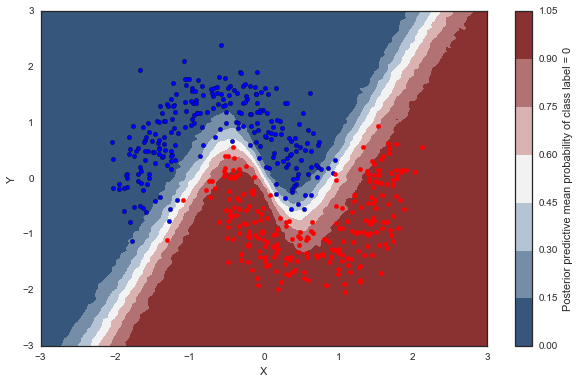

In [16]:
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(10, 6))
contour = ax.contourf(*grid, ppc['out'].mean(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 0');

## Uncertainty in predicted value
So far, everything I showed we could have done with a non-Bayesian Neural Network. The mean of the posterior predictive for each class-label should be identical to maximum likelihood predicted values. However, we can also look at the standard deviation of the posterior predictive to get a sense for the uncertainty in our predictions. Here is what that looks like:

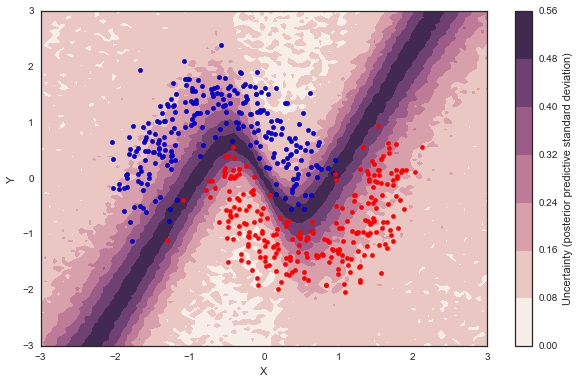

In [17]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(10, 6))
contour = ax.contourf(*grid, ppc['out'].std(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Uncertainty (posterior predictive standard deviation)');

We can see that very close to the decision boundary, our uncertainty as to which label to predict is highest. You can imagine that associating predictions with uncertainty is a critical property for many applications like health care. To further maximize accuracy, we might want to train the model primarily on samples from that high-uncertainty region.

## Mini-batch ADVI: Scaling data size
So far, we have trained our model on all data at once. Obviously this won’t scale to something like ImageNet. Moreover, training on mini-batches of data (stochastic gradient descent) avoids local minima and can lead to faster convergence.

Fortunately, ADVI can be run on mini-batches as well. It just requires some setting up:

In [18]:
from six.moves import zip

# Set back to original data to retrain
ann_input.set_value(X_train)
ann_output.set_value(Y_train)

# Tensors and RV that will be using mini-batches
minibatch_tensors = [ann_input, ann_output]
minibatch_RVs = [out]

# Generator that returns mini-batches in each iteration
def create_minibatch(data):
    rng = np.random.RandomState(0)

    while True:
        # Return random data samples of set size 100 each iteration
        ixs = rng.randint(len(data), size=50)
        yield data[ixs]

minibatches = zip(
    create_minibatch(X_train),
    create_minibatch(Y_train),
)

total_size = len(Y_train)

While the above might look a bit daunting, I really like the design. Especially the fact that you define a generator allows for great flexibility. In principle, we could just pool from a database there and not have to keep all the data in RAM.

Lets pass those to advi_minibatch():

In [19]:

%%time

with neural_network:
    # Run advi_minibatch
    v_params = pm.variational.advi_minibatch(
        n=50000, minibatch_tensors=minibatch_tensors,
        minibatch_RVs=minibatch_RVs, minibatches=minibatches,
        total_size=total_size, learning_rate=1e-2, epsilon=1.0
    )

Iteration 0 [0%]: ELBO = -274.76
Iteration 5000 [10%]: Average ELBO = -215.93
Iteration 10000 [20%]: Average ELBO = -125.8
Iteration 15000 [30%]: Average ELBO = -123.13
Iteration 20000 [40%]: Average ELBO = -121.63
Iteration 25000 [50%]: Average ELBO = -122.45
Iteration 30000 [60%]: Average ELBO = -121.97
Iteration 35000 [70%]: Average ELBO = -122.34
Iteration 40000 [80%]: Average ELBO = -122.85
Iteration 45000 [90%]: Average ELBO = -121.64
Finished [100%]: ELBO = -124.2
CPU times: user 8.92 s, sys: 762 ms, total: 9.68 s
Wall time: 13.7 s


In [20]:
with neural_network:
    trace = pm.variational.sample_vp(v_params, draws=5000)

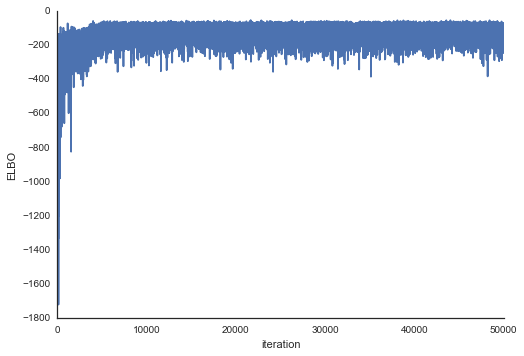

In [21]:
plt.plot(v_params.elbo_vals)
plt.ylabel('ELBO')
plt.xlabel('iteration')
sns.despine()

As you can see, mini-batch ADVI’s running time is much lower. It also seems to converge faster.

For fun, we can also look at the trace. The point is that we also get uncertainty of our Neural Network weights.

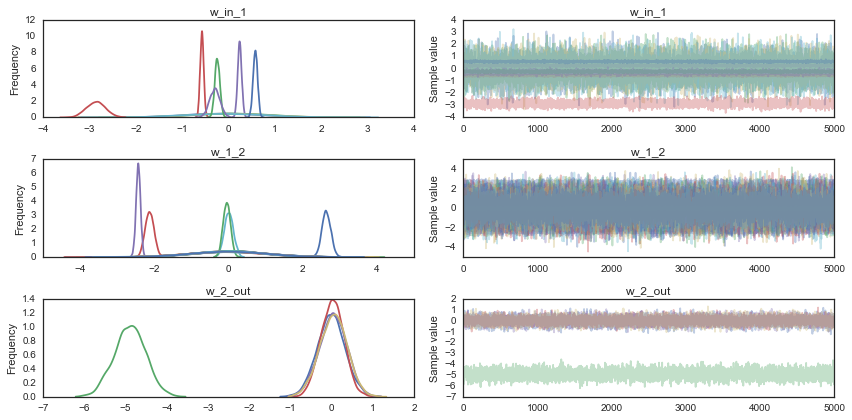

In [22]:
pm.traceplot(trace);


## Summary
Hopefully this blog post demonstrated a very powerful new inference algorithm available in PyMC3: ADVI. I also think bridging the gap between Probabilistic Programming and Deep Learning can open up many new avenues for innovation in this space, as discussed above. Specifically, a hierarchical neural network sounds pretty bad-ass. These are really exciting times.